# Inferential Statistics III - Bayesian

## Introduction

In the last two subunits, you've encountered two schools for performing inference from samples. The Frequentist school calls upon a body of theory established over the past couple of centuries or so. Under certain assumptions and conditions, this allows us to calculate what we would expect to see if an experiment were to be repeated again and again and again. The expected value of the average of a sample is one such statistic we can calculate a result for, even if the originating distribution is far from normal. The bootstrap school, on the other hand, literally does (virtually) run that experiment again and again and again and empirically observes the multitude of outcomes. It then empirically calculates a statistic of interest. While this can be for exactly the same statistics that frequentism calculates (e.g. the mean of a sample) this empirical approach can also perform inference on statistics that do not have well known sampling distributions. Because of the requirement to repeat many, many redraws (with replacement) from the sample, this approach only became feasible with modern computing power.

And thus we come to the Bayesian school of inference. Here we frame our probabilities not so much in terms of "how many times would I expect this event to occur if the experiment were to be rerun many times" but rather in terms of "what is my belief in the likelihood of this event occurring?" In a Bayesian probabilistic programming context, we can build models for systems and then let the data tell us how likely certain values for our model parameters are. This can be a very useful way to incorporate prior knowledge and deal with limited data. It can just be more than a _little_ fiddly to produce a good model!

## Medical charge data set

For the final mini-project of the stats unit, you'll once again return tot he medical charge data you've used for the other mini-projects. Previously, we considered whether we believed that the actual average(non-insured) charge had fallen below a certain threshold.

The hospital is now reviewing its financial resiliency plan, which requires a model for revenue under a range of conditions that include the number of patients treated. Its current model is based on a confidence interval for the mean, and scaling that by different numbers of patients for each scenario. This approach has a number of limitations, most acutely the breakdown of the central limit theorem for low patient volumes; the current model does not do a good job of reflecting the variability in revenue you would see as the number of cases drops. A bootstrap approach would return samples of the same size as the original. Taking subsamples would restrict the sampling to the values already present in the original sample and would not do a good job of representing the actual variability you might see. What is needed is a better model of individual charges.

So the problem here is that we want to model the distribution of individual charges and _we also really want to be able to capture our uncertainty about that distribution_ so we can better capture the range of values we might see. This naturally leads us to a powerful, probabilistic approach — we'll use the pymc3 library to perform Bayesian inference.

### Loading the data and performing an initial view

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from scipy.stats import gamma
import scipy.stats as st
from scipy.stats import norm
import seaborn as sns; sns.set_style('darkgrid')
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [2]:
# read in the data
medical = pd.read_csv('data/insurance2.csv')

In [3]:
# examine a few entries
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
# divide entries by claim type
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
# define variables for number of entries in each claim type
n_ins = len(insurance)
n_no_ins = len(no_insurance)

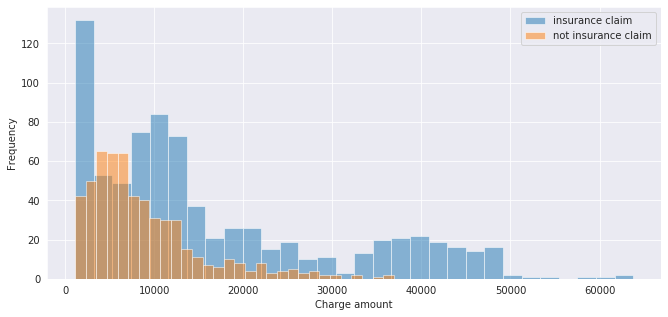

In [5]:
# plot histogram overlapping two claim types
figsize(11, 5)
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

We may suspect from the above that there is some sort of exponential-like distribution at play here. The charges that were not insurance claims seem most like this. The insurance claim charges may possibly be multimodal. The gamma distribution may be applicable and we could test this for the distribution of charges that weren't insurance claims first. Developing our new method for the easiest looking case first is a common and sound approach that can demonstrate a minimum viable solution/product and get, or keep, stakeholders on board.

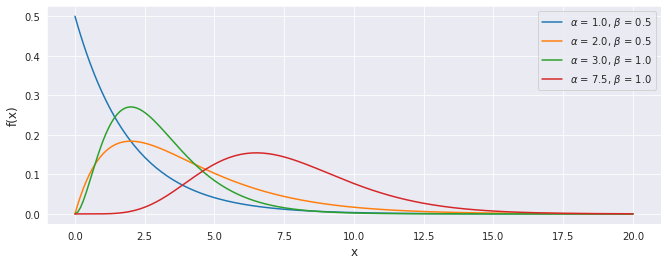

In [6]:
# looking at the form of the gamma distribution
figsize(11, 4)

x = np.linspace(0, 20, 200)
alphas = [1., 2., 3., 7.5]
betas = [.5, .5, 1., 1.]

for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))

plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

### Initial parameter estimation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

In [7]:
# best guesses for parameters of a gamma distribution
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250895, 4702.486170152818)

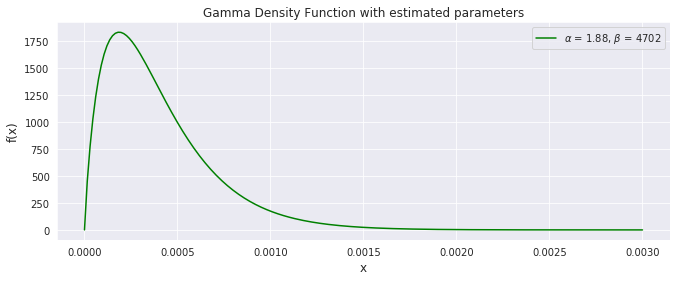

In [8]:
# plot our current best guess to observe shape
figsize(11, 4)

x_range = np.linspace(0, 0.003, 200)

plt.plot(x_range, st.gamma.pdf(x_range, a=alpha_est, scale=(1/beta_est)), 'g-', 
         label=r'$\alpha$ = {}, $\beta$ = {}'.format('1.88', '4702'))

plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)

plt.legend(loc=1)
plt.title('Gamma Density Function with estimated parameters');

### Initial simulation

Let's draw the same number of random variates from this distribution and compare to our observed data.

In [9]:
seed(47)
# simulate uninsured data
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

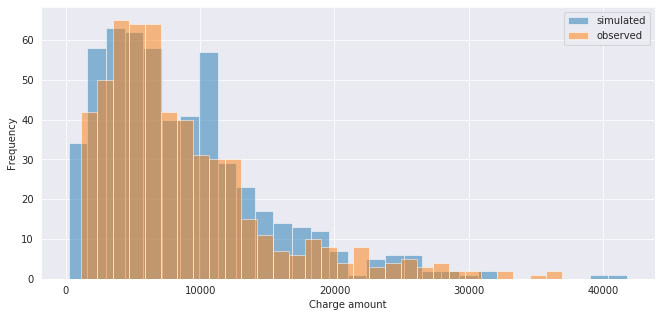

In [10]:
# plot overlapping observed and simulated data
figsize(11, 5)

_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')

_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')

_ = plt.legend()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a _best_ estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [11]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250895, 0.00021265346963636103)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.

__A:__

In [12]:
seed(47)
# create model
with pm.Model() as model:
    # assume exponential prior for alpha parameter to use in Gamma
    alpha_ = pm.Exponential("alpha_", 1 / alpha_est)
    # assume exponential prior for beta parameter to use in Gamma
    rate_ = pm.Exponential("rate_", 1 / rate_est)
    # assume gamma for liklihood of no_insurance distribution
    no_insurance_prior = pm.Gamma("no_insurance_prior", alpha=alpha_, beta=rate_, observed=no_insurance)
    # draw samples with adjusted argument
    trace = pm.sample(10000, tune=1000)
    # discard first half of samples from burn-in period
    burned_trace = trace[5000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate_, alpha_]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:11<00:00, 3946.87draws/s]


Look at that draw rate. My machine rocks!

If you get a warning about acceptance probability not matching the target, and that it's around 0.88 when it should be close to 0.8, don't worry. We encourage you to read up on this and see if you can adjust the parameters and/or arguments to pm.sample, but if your model runs without any additional warnings or errors then you should be doing great!

__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

__A:__

In [13]:
# define the observations to use for analysis
alpha_vals = burned_trace['alpha_']
beta_vals = 1 / burned_trace['rate_']

In [14]:
# obtain credible interval for gamma parameters
ci_95_alpha = np.percentile(alpha_vals, [2.5, 97.5])
print('The 95% credible interval of alpha is ({}, {}).'
      .format(format(ci_95_alpha[0], '.3f'), (format(ci_95_alpha[1], '.3f'))))
ci_95_beta = np.percentile(beta_vals, [2.5, 97.5])
print('The 95% credible interval of beta is ({}, {}).'
      .format(format(ci_95_beta[0], '.0f'), (format(ci_95_beta[1], '.0f'))))

The 95% credible interval of alpha is (1.992, 2.482).
The 95% credible interval of beta is (3509, 4494).


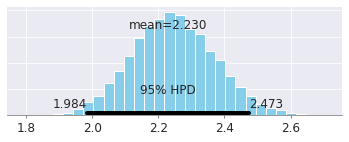

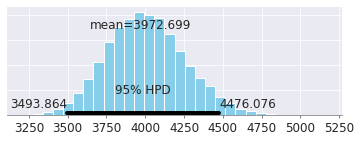

In [15]:
# looking at information for the posterior distribution using pyMC3 built-in function
pm.plot_posterior(alpha_vals)
pm.plot_posterior(beta_vals);

Getting the 95% credible interval from different libraries yields similar results up to 2 significant figures.

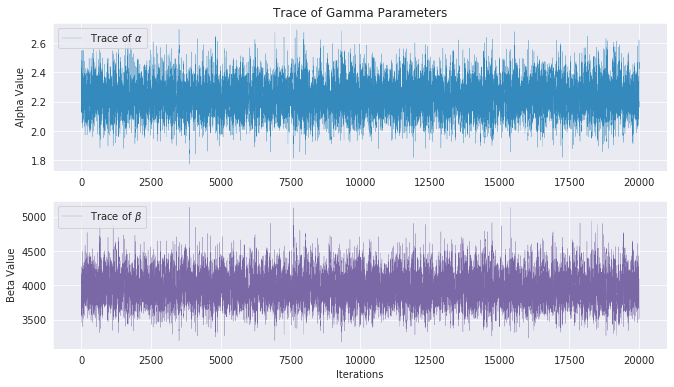

In [16]:
# make line plots of traces of gamma parameters
figsize(11, 6)

plt.subplot(211)
plt.plot(np.arange(20000), alpha_vals, linewidth=0.25, label=r'Trace of $\alpha$', color='#348ABD')

plt.ylabel('Alpha Value')

plt.legend(loc=2)
plt.title('Trace of Gamma Parameters')

plt.subplot(212)
plt.plot(np.arange(20000), beta_vals, linewidth=0.25, label=r'Trace of $\beta$', color='#7A68A6')

plt.xlabel('Iterations')
plt.ylabel('Beta Value')

plt.legend(loc=2);

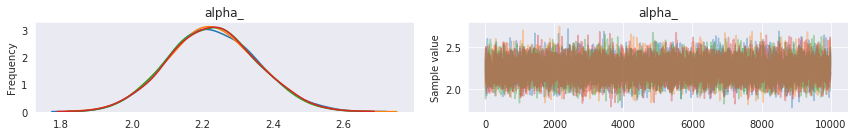

In [17]:
# looking at simulated posterior distribution for 3 independent Markov Chains and sample values for each iteration
pm.traceplot(trace, varnames=['alpha_'],);

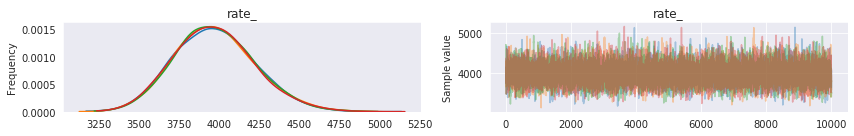

In [18]:
# and now for beta
pm.traceplot(trace, varnames=['rate_'], transform=(lambda x: 1/x));

From this we can see that the chains have converged.

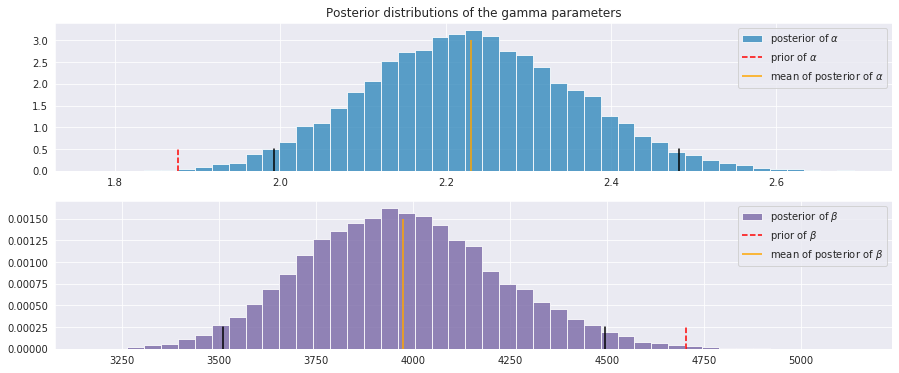

In [19]:
# plot histograms of gamma parameter samples
figsize(15, 6)

# plot alpha samples
plt.subplot(211)
plt.hist(alpha_vals, bins=45, alpha=0.8, label=r'posterior of $\alpha$', color='#348ABD', density=True)
# plot prior alpha (best guess)
plt.vlines(alpha_est, 0, 0.5, linestyle='--', label=r'prior of $\alpha$', colors='red')
# plot credible interval lines
plt.axvline(x=ci_95_alpha[0], ymax=np.e ** (-0.5 * norm.ppf(.975) ** 2), color='black')
plt.axvline(x=ci_95_alpha[1], ymax=np.e ** (-0.5 * norm.ppf(.975) ** 2), color='black')
#plot mean of posterior of alpha
plt.vlines(alpha_vals.mean(), 0, 3, linestyle='-', label=r'mean of posterior of $\alpha$', colors='orange')

plt.legend()
plt.title('Posterior distributions of the gamma parameters')

# plot beta samples
plt.subplot(212)
plt.hist(beta_vals, bins=45, alpha=0.8, label=r'posterior of $\beta$', color='#7A68A6', density=True)
# plot prior beta (best guess)
plt.vlines(beta_est, 0, 0.00025, linestyle='--', label=r'prior of $\beta$', colors='red')
# plot credible interval lines
plt.axvline(x=ci_95_beta[0], ymax=np.e ** (-0.5 * norm.ppf(.975) ** 2), color='black')
plt.axvline(x=ci_95_beta[1], ymax=np.e ** (-0.5 * norm.ppf(.975) ** 2), color='black')
#plot mean of posterior of beta
plt.vlines(beta_vals.mean(), 0, 0.0015, linestyle='-', label=r'mean of posterior of $\beta$', colors='orange')

plt.legend();

From this it can be observed that the initial guesses were fairly off.

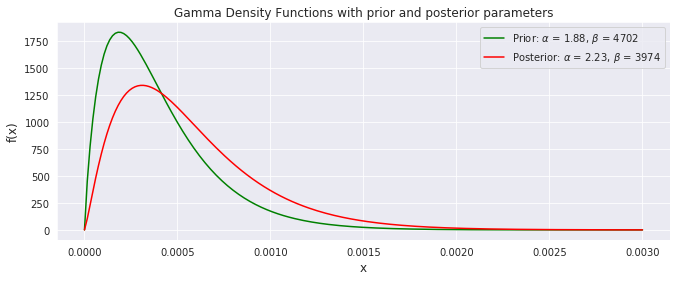

In [20]:
# plot our prior and posterior best guesses
figsize(11, 4)

x_range = np.linspace(0, 0.003, 200)

plt.plot(x_range, st.gamma.pdf(x_range, a=alpha_est, scale=(1/beta_est)), 'g-', 
         label=r'Prior: $\alpha$ = {}, $\beta$ = {}'.format('1.88', '4702'))
plt.plot(x_range, st.gamma.pdf(x_range, a=alpha_vals.mean(), scale=(1/beta_vals.mean())), 'r-', 
         label=r'Posterior: $\alpha$ = {}, $\beta$ = {}'.format('2.23', '3974'))

plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)

plt.legend(loc=1)
plt.title('Gamma Density Functions with prior and posterior parameters');

The curve is flattened a bit.

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__

In [21]:
# look for diverging chains
trace.get_sampler_stats('diverging').sum()

0

There were no divergences after burn-in.

In [22]:
# verify convergence using Gelman-Rubin
pm.gelman_rubin(trace)

{'alpha_': 0.9999944892442677, 'rate_': 1.0000009538448114}

Both potential scale reduction factors are close to 1.<br>
This means that the between chain variance is small, and both chains are mixing around the stationary distribution.<br>
If the factors were greater than 1.1, we would need a longer burn-in.

In [23]:
# setting up for the Geweke Score
alpha_score = pm.geweke(trace['alpha_'], first=0.1, last=0.5, intervals=90)
beta_score = pm.geweke(trace['rate_'], first=0.1, last=0.5, intervals=100)

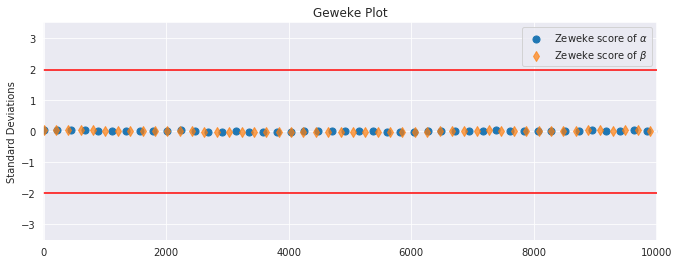

In [24]:
# plot the Geweke scores
figsize(11, 4)
# overlay scatterplots
plt.scatter(alpha_score[:, 0], alpha_score[:, 1], marker = 'o', s=50, label=r'Zeweke score of $\alpha$')
plt.scatter(beta_score[:, 0], beta_score[:, 1], alpha=0.7, marker = 'd', s=50, label=r'Zeweke score of $\beta$')
# draw in the standard deviation lines
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')

plt.ylim(-3.5, 3.5)
plt.xlim(0 - 10, 0.5 * trace['alpha_'].shape[0] / 2 + 10)
plt.ylabel('Standard Deviations')
plt.legend()
plt.title('Geweke Plot');

This compares the mean z-score of the first 10% of the chain with the last 50%.<br>
Absolute value less than 1 standard deviations signifies convergence, and that the sampling size is large enough.

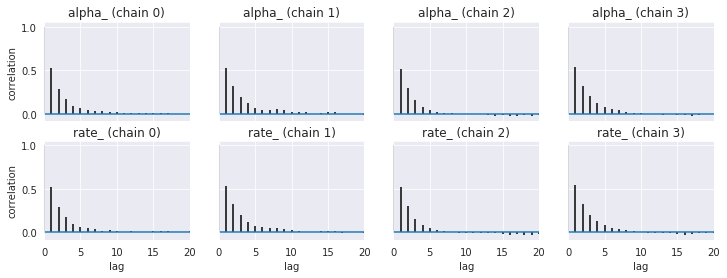

In [25]:
# test for correlation between samples in the chains
pm.autocorrplot(trace, max_lag=20);

The burn-in is quick. If present, high autocorrelation could be addressed by thinning the chains prior to use.

In [26]:
# test auto-correlation through the effective sample size
pm.diagnostics.effective_n(trace)

{'alpha_': 10898.550346017559, 'rate_': 10757.938938415982}

This number should be close to the sample size to rule out autocorrelation, as well.

In [27]:
# compute the Watanabe-Akaike information criterion
pm.waic(trace, model).WAIC

/home/lord_black/anaconda3/envs/movieCap1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


11031.928421304876

This could be used if I were comparing different models for things such as overfitting or averaging along multiple models through weighting.

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__

In [28]:
# get average of posteriors for gamma parameters
alpha_best = np.mean(alpha_vals)
beta_best = np.mean(beta_vals)

print('The average posterior value of alpha is {}.'.format(format(alpha_best, '.3f')))
print('The average posterior value of beta is {}.'.format(format(beta_best, '.0f')))

The average posterior value of alpha is 2.230.
The average posterior value of beta is 3973.


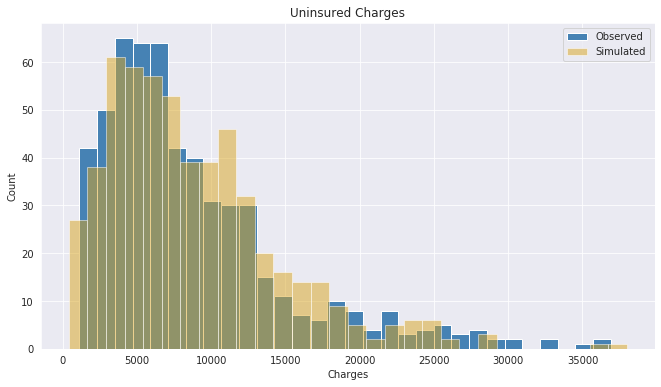

In [29]:
# simulate uninsured distribution
seed(47)
best_shot_simulated = gamma(alpha_best, scale=beta_best).rvs(n_no_ins)
# plot overlapping histograms comparing observed and simulated data
figsize(11, 6)

plt.hist(no_insurance, bins=30, label='Observed', color='steelblue')
plt.hist(best_shot_simulated, bins=30, label='Simulated', alpha=0.5, color='goldenrod')

plt.xlabel('Charges')
plt.ylabel('Count')

plt.title('Uninsured Charges')
plt.legend();

The new plot looks like a great fit.

## Summary

In this exercise, we have postulated a distribution to describe the individual charge amounts for non-insured cases. This distribution has two required parameters, which we do not know, but we used PyMC3 to perform Bayesian inference to find our level of "belief" in a range of values for them. We then used the average parameter values to create one simulated data set of the same size as the original, but the distribution of our posteriors for these parameters will allow us to perform simulations of any sample size we desire and for a range of scenarios of different $\alpha$ and $\beta$. This could be a powerful tool to model different financial conditions for the hospital. 

Well done making it through this tricky subject. Starting think Bayesian _and_ starting to get to grips with something like PyMC3 is no easy task. As a data scientist, the most important thing is to be aware that this statistical approach exists, though you may not actually use this approach as much as you use the other approaches you've learned about. Still, we encourage you to think of ways that this approach could apply to the work that you do in this course and throughout your career.  